##Neural Network Library
Here we are going to implement a neural network library which helps us to make predictions on the complex datasets which has the computation power of human neurons.

##Note:
In this notebook itself I am including the report along with the code too and the report file(colab notebook pdf file) which I am submitting contains the output after running multiple times but the comparison I mentioned were has different values than that of report pdf file.

Thank you


In [100]:
import numpy as np
import pickle

##1.Layer Class
The Layer class serves as a foundational blueprint for neural network layers, abstracting forward and backward pass methods. This enables polymorphism, allowing seamless integration and processing across various layer types within a network, enhancing modularity and flexibility in constructing and training neural models.

In [101]:
class Layer:
    def __init__(self):
        pass
    def forward_pass(self):
        pass
    def backward_pass(self):
        pass

##2.Linear Layer
The Linear Layer class, inheriting from Layer, implements forward and backward functions for neural network computations. It calculates outputs using input, weights, and biases, and during backpropagation, computes gradients for weights, biases, and inputs, facilitating learning through gradient descent in multi-layer networks.

In [102]:
class LinearLayer(Layer):

    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size #refers to the number of inputs
        self.output_size = output_size #refers to the number of outputs that a layer generates
        # Initializing weights and biases
        self.weights = np.random.randn(input_size, output_size)
        self.biases = np.zeros((1, output_size))
        self.inputs = None

    def forward_pass(self,inputs):
        self.inputs = inputs #assigning the inputs
        #This line refers to the linear combination of inputs y = mx+c
        return np.dot(inputs, self.weights) + self.biases

    def backward_pass(self,outputs,regularization):
        self.derived_weights = np.dot(self.inputs.T,outputs)+(regularization*self.weights) #calculating the derived weights
        self.derived_biases = np.sum(outputs, axis=0, keepdims=True) #calculating the derived biases
        derived_inputs = np.dot(outputs, self.weights.T) #calculating the derived inputs

        return derived_inputs

##3.Sigmoid Function
The Sigmoid class extends the Layer class to apply the logistic sigmoid activation function during the forward pass, storing the result for reuse. In the backward pass, it computes the derivative of the sigmoid function, essential for the gradient descent backpropagation process in neural networks.

In [103]:
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
        self.outputs = None

    def forward_pass(self,inputs):
        #logistic sigmoid function which ranges the outputs between [0,1]
        self.outputs = 1/(1+np.exp(-inputs))
        return self.outputs

    def backward_pass(self,outputs):
        return outputs * self.outputs * (1-self.outputs) #gradient of sigmoid function

##4.ReLU Function (Rectified Linear Units)
The ReLU class, inheriting from Layer, applies the Rectified Linear Unit activation, which sets negative inputs to zero during the forward pass. Its backward function calculates gradients for the subsequent optimization step, pivotal for learning non-linear decision boundaries in neural networks.

In [104]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()
        self.mask = None

    def forward_pass(self,inputs):
        self.mask = (inputs <= 0) #checking whether the inputs is less than or equal to zero
        #if input is negative it gives zero or gives the input as it is
        output = np.maximum(0, inputs)
        return output

    def backward_pass(self,outputs):
        outputs[self.mask] = 0 #returning the inputs which are positive
        return outputs


##5.Binary Cross Entropy Loss Function
The BinaryCrossEntropyLoss class, extending Layer, computes the binary cross-entropy loss for binary classification tasks like the XOR problem. Its forward pass measures the discrepancy between predicted and true values, while the backward pass computes gradients essential for updating model parameters.

In [105]:
class BinaryCrossEntropy(Layer):
    def __init__(self):
        super().__init__()
        self.inputs = None
        self.targets = None

    def forward_pass(self,inputs,targets):
        #assigning the inputs and targets
        self.inputs = inputs
        self.targets = targets
        # Avoiding the division by zero and clip values
        inputs_clipped = np.clip(inputs, 1e-12, 1 - 1e-12)
        loss = -np.mean(targets * np.log(inputs_clipped) + (1 - targets) * np.log(1 - inputs_clipped))
        return loss

    def backward_pass(self):
        # Avoiding the division by zero and clip values
        inputs_clipped = np.clip(self.inputs, 1e-12, 1 - 1e-12)
        #calculating the gradient of the entropy loss
        d_inputs = -(self.targets / inputs_clipped) + ((1 - self.targets) / (1 - inputs_clipped))
        d_inputs /= self.inputs.shape[0]  # Average over the number of samples
        return d_inputs

##6.Tanh Function

The hyperbolic tangent (tanh) function, commonly used in neural networks, smoothly maps input values to a range between -1 and 1. In the forward pass, it provides non-linear activation. During the backward pass, its derivative, (1-tanh^2(x)) facilitates gradient flow for learning.








In [106]:
class Tanh(Layer):
    def forward_pass(self, inputs):
        # Compute the tanh activation for each input
        self.outputs = np.tanh(inputs)
        return self.outputs

    def backward_pass(self, d_values):
        # Derivative of tanh(x) is (1 - tanh^2(x))
        # Since self.outputs = tanh(inputs), then the derivative is:
        d_inputs = (1 - self.outputs ** 2) * d_values
        return d_inputs

##7.Seqeuntial Class
The Sequential class serves as a container for organizing layers linearly in a neural network. Inheriting from the Layer class, it enables the stacking of different layers, simplifying model construction. It manages the forward and backward passes through the network by sequentially invoking these processes on its contained layers, facilitating gradient computation and parameter updates.



In [107]:
class Sequential(Layer):
    def __init__(self):
        super().__init__()
        self.layers = []

    def add(self, layer):
        self.layers.append(layer) #appending the layers

    def forward_pass(self,inputs):
        output = inputs
        for layer in self.layers:
            #calculates the forward pass for each layer
            output = layer.forward_pass(output)
        return output

    def backward_pass(self,outputs, regularization):
          derived_inputs = outputs
          for layer in reversed(self.layers):
            if isinstance(layer,LinearLayer):
              #passing the learning rate to the linear layer and calculating the backward pass
              derived_inputs = layer.backward_pass(derived_inputs,regularization)
            else:
              #calculating the backward pass for other layers
              derived_inputs = layer.backward_pass(derived_inputs)
          return derived_inputs

    def save_weights(self, file_path):
       #saving the weights
        weights = [layer.weights for layer in self.layers if hasattr(layer, 'weights')]
        with open(file_path, 'wb') as file:
            pickle.dump(weights, file)

    def load_weights(self, file_path):
      #loading the weights
        with open(file_path, 'rb') as file:
            weights = pickle.load(file)
        for layer, layer_weights in zip(self.layers, weights):
            if hasattr(layer, 'weights'):
                layer.weights = layer_weights


In [108]:
#XOR Problem
#initializing the train and test values
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

##Note
Whenever we run the below models for multiple times it may produces different outputs so the comparison I made here indicates the output of at that particular time of running the models.

##Sigmoid Implementation

Here we implemented the sigmoid function for resolving the XOR problem by passing a learning rate of 0.1, using **BinaryCrossEntropy** loss function and implementing and training the model using epochs and we can see the loss being descreased for every epoch it trains through

In [109]:
model_sigmoid = Sequential() #creating Sequential class object
model_sigmoid.add(LinearLayer(input_size=2, output_size=2)) # Input layer to hidden layer
model_sigmoid.add(Sigmoid())                                # Activation for hidden layer
model_sigmoid.add(LinearLayer(input_size=2, output_size=1)) # Hidden layer to output layer
model_sigmoid.add(Sigmoid())                                # Activation for output layer

learning_rate = 0.1
regularization = 0
loss_function = BinaryCrossEntropy()
n_epochs = 10000  # Number of epochs (iterations over the dataset)

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model_sigmoid.forward_pass(X)
    loss = loss_function.forward_pass(y_pred, y)

    # Backward pass
    d_loss = loss_function.backward_pass()
    model_sigmoid.backward_pass(d_loss,regularization)

    for layer in model_sigmoid.layers:
      if isinstance(layer, LinearLayer):
          layer.weights -= learning_rate * layer.derived_weights
          layer.biases -= learning_rate * layer.derived_biases


    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss}") #printing the loss for every 1000 epochs

model_sigmoid.save_weights('XOR_solved_sigmoid.w') #saving the weights as XOR_solved_Sigmoid.w

Epoch 0, Loss: 0.7417641868970463
Epoch 1000, Loss: 0.6852568122293645
Epoch 2000, Loss: 0.6150041896153824
Epoch 3000, Loss: 0.41781628177783436
Epoch 4000, Loss: 0.12855098448298743
Epoch 5000, Loss: 0.061245122442281905
Epoch 6000, Loss: 0.0388718189618532
Epoch 7000, Loss: 0.028170672114705954
Epoch 8000, Loss: 0.021984695204220195
Epoch 9000, Loss: 0.01798015670868499


##Tanh Implementation
Here we implemented the Tanh function for resolving the XOR problem by passing a learning rate of 0.1, using BinaryCrossEntropy loss function and implementing and training the model using epochs and we can see the loss being descreased for every epoch it trains through

In [110]:
model_Tanh = Sequential()
model_Tanh.add(LinearLayer(input_size=2, output_size=2)) # Input layer to hidden layer
model_Tanh.add(Tanh())                                # Activation for hidden layer
model_Tanh.add(LinearLayer(input_size=2, output_size=1)) # Hidden layer to output layer
model_Tanh.add(Tanh())                                # Activation for output layer

learning_rate = 0.1
regularization = 0
loss_function = BinaryCrossEntropy()
n_epochs = 10000  # Number of epochs (iterations over the dataset)

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model_Tanh.forward_pass(X)
    loss = loss_function.forward_pass(y_pred, y)

    # Backward pass
    d_loss = loss_function.backward_pass()
    model_Tanh.backward_pass(d_loss,regularization)

    for layer in model_Tanh.layers:
      if isinstance(layer, LinearLayer):
          layer.weights -= learning_rate * layer.derived_weights
          layer.biases -= learning_rate * layer.derived_biases


    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss}") #printing the loss for every 1000 epochs

model_Tanh.save_weights('XOR_solved_Tanh.w') #saving the weights as XOR_solved_Tanh.w

Epoch 0, Loss: 13.815510557964773
Epoch 1000, Loss: 13.815521618947178
Epoch 2000, Loss: 13.815521618947178
Epoch 3000, Loss: 13.815521618947178
Epoch 4000, Loss: 13.815521618947178
Epoch 5000, Loss: 13.815521618947178
Epoch 6000, Loss: 13.815521618947178
Epoch 7000, Loss: 13.815521618947178
Epoch 8000, Loss: 13.815521618947178
Epoch 9000, Loss: 13.815521618947178


##ReLU Implementation
Here we implemented the ReLU activation function for resolving the XOR problem by passing a learning rate of 0.1, using BinaryCrossEntropy loss function and implementing and training the model using epochs and we can see the loss being descreased for every epoch it trains through

In [111]:
model_ReLU = Sequential()
model_ReLU.add(LinearLayer(input_size=2, output_size=2)) # Input layer to hidden layer
model_ReLU.add(ReLU())                                   # Activation for hidden layer
model_ReLU.add(LinearLayer(input_size=2, output_size=1)) # Hidden layer to output layer
model_ReLU.add(ReLU())                                   # Activation for output layer

learning_rate = 0.1
regularization = 0
loss_function = BinaryCrossEntropy()
n_epochs = 10000  # Number of epochs (iterations over the dataset)

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model_ReLU.forward_pass(X)
    loss = loss_function.forward_pass(y_pred, y)

    # Backward pass
    d_loss = loss_function.backward_pass()
    model_ReLU.backward_pass(d_loss,regularization)

    for layer in model_ReLU.layers:
      if isinstance(layer, LinearLayer):
          layer.weights -= learning_rate * layer.derived_weights
          layer.biases -= learning_rate * layer.derived_biases


    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")#printing the loss for every 1000 epochs

model_sigmoid.save_weights('XOR_solved_ReLU.w')#saving the weights as XOR_solved_ReLU.w

Epoch 0, Loss: 6.9077552789828855
Epoch 1000, Loss: 13.815510557964773
Epoch 2000, Loss: 13.815510557964773
Epoch 3000, Loss: 13.815510557964773
Epoch 4000, Loss: 13.815510557964773
Epoch 5000, Loss: 13.815510557964773
Epoch 6000, Loss: 13.815510557964773
Epoch 7000, Loss: 13.815510557964773
Epoch 8000, Loss: 13.815510557964773
Epoch 9000, Loss: 13.815510557964773


##Comparison for above models

**Conclusion**

Based on the above outputs, the *Sigmoid* and *Tanh* activation functions showed decreasing loss values over epochs, indicating successful learning. However, the Tanh function reached a lower loss more steadily compared to Sigmoid. In contrast, *ReLU* consistently had a high loss, suggesting it struggled to learn the XOR problem. Therefore, for this problem, **Tanh** was easier to train, followed by **Sigmoid**, while **ReLU** faced challenges.

##Predicting Trip Duration

Now using the above implementation of Neural Networks and the respective activation functions we are going to predict the **'Trip Duration'**.

Here it comes under regression problem as we are predicting continous variable(*Dependent feature*) by considering the *Independent features*.

In [112]:
import numpy as np

dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

##1.Data Preprocessing

Here we are going to do data preprocessing which are an important process of steps to ensure our data is perfect,correctly transormed and normalized.

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#converting the above numpy data into dataframes using pandas
df_1 = pd.DataFrame(X_train)
df_2 = pd.DataFrame(y_train)

df_3 = pd.DataFrame(X_test)
df_4 = pd.DataFrame(y_test)

In [114]:
#concatenating the X_tarin,y_train and X_test,y_test
df = pd.concat([df_1,df_2],axis=1)
df_test = pd.concat([df_3,df_4],axis=1)

In [115]:
df.head() #printing first 5 rows of train dataframe

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
879655,id2425795,1,2016-01-08 23:55:11,2016-01-09 00:04:32,1,-73.955551,40.773346,-73.973640,40.763500,N,561
646838,id0767831,2,2016-03-05 09:52:06,2016-03-05 10:00:12,1,-73.962181,40.763599,-73.980377,40.764919,N,486
1138713,id0449104,1,2016-04-09 16:03:53,2016-04-09 16:21:22,1,-73.977486,40.751842,-74.011688,40.718925,N,1049
864716,id3030157,1,2016-01-06 11:12:44,2016-01-06 11:19:49,1,-73.970001,40.762363,-73.963264,40.774666,N,425
434927,id1584885,1,2016-06-26 09:10:56,2016-06-26 09:17:44,1,-73.950348,40.771561,-73.968178,40.762409,N,408


In [116]:
print(df.shape) #printing the shape of the training dataset
print(df_test.shape) #printing the shape of the test dataset

(1312779, 11)
(145865, 11)


##Checking for Null Values
Here we are checking whether the values of training and test dataset contains null values and we can see there are no null values in both datasets.

In [117]:
#checking whether the values of training and test dataset contains null values
print(df.isnull().sum())
print("-----------------")
print(df_test.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
-----------------
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


Ensuring whether 'trip_duration' is negative or not and we can see there are no negative values.

In [118]:
erroneous_rows = df[df['trip_duration'] < 0] #looking for erroneous data in trip duration of training data
print(erroneous_rows) #checking whether any value is negative or not !!

erroneous_test_rows = df_test[df_test['trip_duration'] < 0] #looking for erroneous data in trip duration of testing data
print(erroneous_test_rows) #checking whether any value is negative or not !!

Empty DataFrame
Columns: [id, vendor_id, pickup_datetime, dropoff_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag, trip_duration]
Index: []
Empty DataFrame
Columns: [id, vendor_id, pickup_datetime, dropoff_datetime, passenger_count, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, store_and_fwd_flag, trip_duration]
Index: []


##Correlation

Here we are plotting the ***correlation matrix*** to check whether which Independent features has positive or negative correlation with the Dependent feature **trip_duration**

We can see in both the datasets trip_duration has negative correlation of both **latitude** features and positive correlation with **longitude** features, **vendor_id** and **passenger_count** features.

<ipython-input-119-2c283e89604d>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df_corr.corr() # defining the correlation variable


<Axes: >

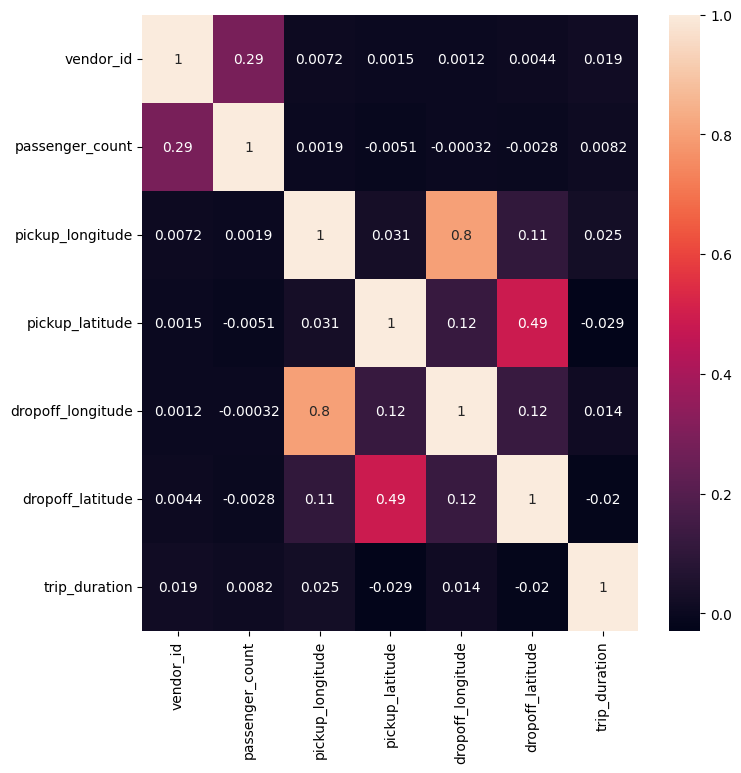

In [119]:
#correlation matrix for training dataset
plt.figure(figsize=(8,8)) # setting the figsize
df_corr = df.drop(columns = 'store_and_fwd_flag')
correlation = df_corr.corr() # defining the correlation variable
#plotting the correlation matrix using heatmap
sns.heatmap(correlation,xticklabels=correlation.columns,yticklabels=correlation.columns,annot=True)

<ipython-input-120-1b88975747c6>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_test = df_test_corr.corr() # defining the correlation variable


<Axes: >

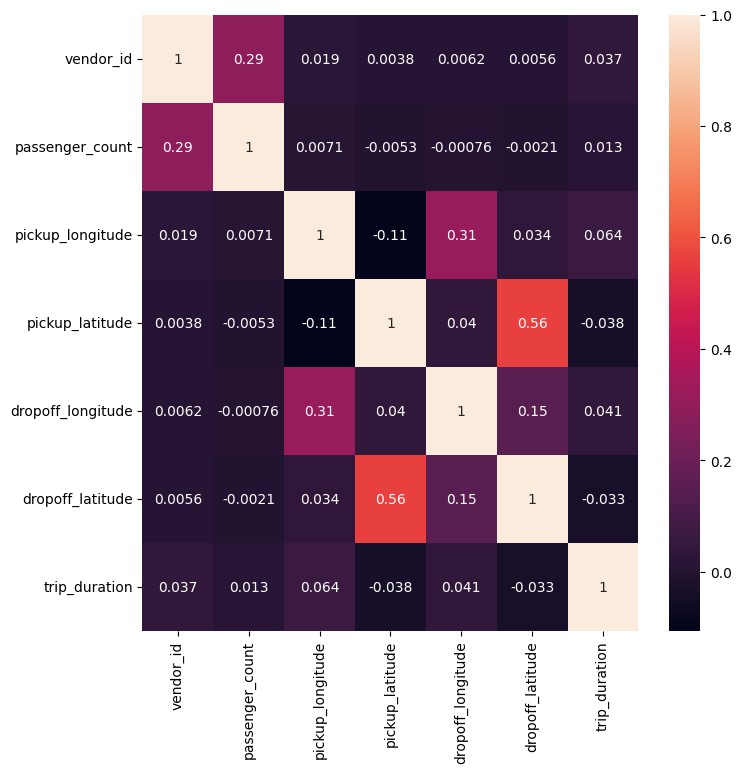

In [120]:
#correlation matrix for test dataset
plt.figure(figsize=(8,8)) # setting the figsize
df_test_corr = df_test.drop(columns = 'store_and_fwd_flag')
correlation_test = df_test_corr.corr() # defining the correlation variable
#plotting the correlation matrix using heatmap
sns.heatmap(correlation_test,xticklabels=correlation_test.columns,yticklabels=correlation_test.columns,annot=True)

#Transformation of features
Here we are transforming the pickup and dropoff dates in both the datasets into the respective **month, hour** and **day of week** such that it makes easy for us to do **time series analysis** to predict the **trip_duration** along with other features.

In [121]:
# Here we are extracting each individual value of month, hour and day of week for training dataset using pickup and dropoff timestamp values

# Extract date
df['pickup_month'] = pd.to_datetime(df['pickup_datetime']).dt.month

# Extract time
df['pickup_hour'] =  pd.to_datetime(df['pickup_datetime']).dt.hour

# Extract day name
df['pickup_day'] =  pd.to_datetime(df['pickup_datetime']).dt.dayofweek

# Extract date
df['drop_month'] = pd.to_datetime(df['dropoff_datetime']).dt.month

# Extract time
df['drop_hour'] =  pd.to_datetime(df['dropoff_datetime']).dt.hour

# Extract day name
df['drop_day'] =  pd.to_datetime(df['dropoff_datetime']).dt.dayofweek

In [122]:
# Here we are extracting each individual value of month, hour and day of week for test dataset using pickup and dropoff timestamp values

# Extract date
df_test['pickup_month'] = pd.to_datetime(df_test['pickup_datetime']).dt.month

# Extract time
df_test['pickup_hour'] =  pd.to_datetime(df_test['pickup_datetime']).dt.hour

# Extract day name
df_test['pickup_day'] =  pd.to_datetime(df_test['pickup_datetime']).dt.dayofweek

# Extract date
df_test['drop_month'] = pd.to_datetime(df_test['dropoff_datetime']).dt.month

# Extract time
df_test['drop_hour'] =  pd.to_datetime(df_test['dropoff_datetime']).dt.hour

# Extract day name
df_test['drop_day'] =  pd.to_datetime(df_test['dropoff_datetime']).dt.dayofweek

Here we are dropping the features in both the datasets such as **'id','vendor_id','pickup_datetime','dropoff_datetime','passenger_count','store_and_fwd_flag'** which are not helpful in predicting the **trip_duration**

In [123]:
#dropping the features which are not helpful in predicting trip_duration for both training and test datasets

df = df.drop(['id','vendor_id','pickup_datetime','dropoff_datetime','passenger_count','store_and_fwd_flag'],axis=1) #training dataset
df_test = df_test.drop(['id','vendor_id','pickup_datetime','dropoff_datetime','passenger_count','store_and_fwd_flag'],axis=1) #test dataset

In [124]:
df.head() #printing first 5 rows of training set

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_hour,pickup_day,drop_month,drop_hour,drop_day
879655,-73.955551,40.773346,-73.973640,40.763500,561,1,23,4,1,0,5
646838,-73.962181,40.763599,-73.980377,40.764919,486,3,9,5,3,10,5
1138713,-73.977486,40.751842,-74.011688,40.718925,1049,4,16,5,4,16,5
864716,-73.970001,40.762363,-73.963264,40.774666,425,1,11,2,1,11,2
434927,-73.950348,40.771561,-73.968178,40.762409,408,6,9,6,6,9,6


In [125]:
df_test.head()#printing the first 5 rows of test set

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_hour,pickup_day,drop_month,drop_hour,drop_day
67250,-73.985611,40.735943,-73.980331,40.760468,1040,6,7,2,6,7,2
1397036,-73.978394,40.764351,-73.991623,40.749859,827,4,12,6,4,13,6
1021087,-73.989059,40.744389,-73.973381,40.748692,614,6,2,6,6,2,6
951424,-73.990326,40.731136,-73.991264,40.748917,867,5,17,3,5,17,3
707882,-73.789497,40.646675,-73.987137,40.759232,4967,5,17,3,5,19,3


##Creating new features

Here we are goint to calculate the **distance_km** feature using **latitude** and **longitude** values along with it we are also going to calculate the **speed** in **kmph(kilometer per hour)** using **distance** and **trip duration** and we are going to drop the latitude and longitude features as we have created distance and speed features

we are also going to convert the **trip_duration** from seconds to hours which makes it more flexible to predict

In [126]:
!pip install haversine #installing the haversine library to calculate the distance

In [127]:
#calculating distance in km using training using latitude and longitude values
from haversine import haversine, Unit

def distance_km(row):
    pickup_lat = row['pickup_latitude']
    pickup_lon = row['pickup_longitude']
    dropoff_lat = row['dropoff_latitude']
    dropoff_lon = row['dropoff_longitude']
    return haversine((pickup_lat, pickup_lon),(dropoff_lat, dropoff_lon))

df['distance_km'] = df.apply(lambda row : distance_km(row), axis=1)

In [128]:
#calculating distance in km for test dataset using latitude and longitude values
from haversine import haversine, Unit

def distance_km(row):
    pickup_lat = row['pickup_latitude']
    pickup_lon = row['pickup_longitude']
    dropoff_lat = row['dropoff_latitude']
    dropoff_lon = row['dropoff_longitude']
    return haversine((pickup_lat, pickup_lon),(dropoff_lat, dropoff_lon))

df_test['distance_km'] = df_test.apply(lambda row : distance_km(row), axis=1)

In [129]:
#here calculating speed in kmph for training dataset by converting the trip_duration into hours by dividing with 3600
df['speed_kmph'] = df['distance_km']/(df['trip_duration']/3600)

In [130]:
#here calculating speed in kmph for test dataset by converting the trip_duration into hours by dividing with 3600
df_test['speed_kmph'] = df_test['distance_km']/(df_test['trip_duration']/3600)

In [131]:
df.head() #printing the first 5 rows of training set

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_hour,pickup_day,drop_month,drop_hour,drop_day,distance_km,speed_kmph
879655,-73.955551,40.773346,-73.973640,40.763500,561,1,23,4,1,0,5,1.875967,12.038289
646838,-73.962181,40.763599,-73.980377,40.764919,486,3,9,5,3,10,5,1.539478,11.403537
1138713,-73.977486,40.751842,-74.011688,40.718925,1049,4,16,5,4,16,5,4.658514,15.987276
864716,-73.970001,40.762363,-73.963264,40.774666,425,1,11,2,1,11,2,1.480944,12.544464
434927,-73.950348,40.771561,-73.968178,40.762409,408,6,9,6,6,9,6,1.813889,16.004901


In [132]:
df_test.head() #printing the first 5 rows of test set

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_hour,pickup_day,drop_month,drop_hour,drop_day,distance_km,speed_kmph
67250,-73.985611,40.735943,-73.980331,40.760468,1040,6,7,2,6,7,2,2.763053,9.564416
1397036,-73.978394,40.764351,-73.991623,40.749859,827,4,12,6,4,13,6,1.959181,8.528479
1021087,-73.989059,40.744389,-73.973381,40.748692,614,6,2,6,6,2,6,1.404774,8.236458
951424,-73.990326,40.731136,-73.991264,40.748917,867,5,17,3,5,17,3,1.978662,8.215900
707882,-73.789497,40.646675,-73.987137,40.759232,4967,5,17,3,5,19,3,20.837774,15.102876


In [133]:
#'distance_km','speed_kmph'

df_y_train = df['trip_duration']/3600 #converting trip_duration from seconds into hours for training set
#as we calculated the distance and speed no we are dropping the latitude and longitude values for training set
df_X_train = df.drop(['trip_duration','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

df_y_test = df_test['trip_duration']/3600 #converting trip_duration from seconds into hours testing(Validation) set
#as we calculated the distance and speed no we are dropping the latitude and longitude values for test set
df_X_test = df_test.drop(['trip_duration','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'],axis=1)

In [134]:
df_X_train.head() #printing the first 5 rows of input features of train set

,pickup_month,pickup_hour,pickup_day,drop_month,drop_hour,drop_day,distance_km,speed_kmph
879655,1,23,4,1,0,5,1.875967,12.038289
646838,3,9,5,3,10,5,1.539478,11.403537
1138713,4,16,5,4,16,5,4.658514,15.987276
864716,1,11,2,1,11,2,1.480944,12.544464
434927,6,9,6,6,9,6,1.813889,16.004901


In [135]:
df_X_test.head() #printing the first 5 rows of input features of test set

,pickup_month,pickup_hour,pickup_day,drop_month,drop_hour,drop_day,distance_km,speed_kmph
67250,6,7,2,6,7,2,2.763053,9.564416
1397036,4,12,6,4,13,6,1.959181,8.528479
1021087,6,2,6,6,2,6,1.404774,8.236458
951424,5,17,3,5,17,3,1.978662,8.215900
707882,5,17,3,5,19,3,20.837774,15.102876


In [136]:
df_y_train.head() #printing first 5 rows of train's target variable

879655     0.155833
646838     0.135000
1138713    0.291389
864716     0.118056
434927     0.113333
Name: trip_duration, dtype: float64

In [137]:
df_y_test.head() #printing first 5 rows of test's target variable

67250      0.288889
1397036    0.229722
1021087    0.170556
951424     0.240833
707882     1.379722
Name: trip_duration, dtype: float64

##Normalization

This is the important step where we normalize our train and test set variables to ensure they are on same scale.

1.Here I have used **MinMaxScaling** for both train and test sets which ensures each input feature will be in the range of [0,1]

2.I have transformed the target variable (**trip_duration**) using **log transformation** which makes ensure that the distribution of the data going to be normal.

In [138]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_normalize = ['pickup_month','pickup_hour','pickup_day','drop_month','drop_hour','drop_day','distance_km','speed_kmph']


df_X_train[columns_to_normalize] = scaler.fit_transform(df_X_train[columns_to_normalize])
df_X_test[columns_to_normalize] = scaler.fit_transform(df_X_test[columns_to_normalize])


In [139]:
df_X_train.head()

,pickup_month,pickup_hour,pickup_day,drop_month,drop_hour,drop_day,distance_km,speed_kmph
879655,0.0,1.000000,0.666667,0.000000,0.000000,0.833333,0.001512,0.001298
646838,0.4,0.391304,0.833333,0.333333,0.434783,0.833333,0.001241,0.001230
1138713,0.6,0.695652,0.833333,0.500000,0.695652,0.833333,0.003754,0.001724
864716,0.0,0.478261,0.333333,0.000000,0.478261,0.333333,0.001193,0.001353
434927,1.0,0.391304,1.000000,0.833333,0.391304,1.000000,0.001462,0.001726


In [140]:
df_X_test.head()

,pickup_month,pickup_hour,pickup_day,drop_month,drop_hour,drop_day,distance_km,speed_kmph
67250,1.0,0.304348,0.333333,0.833333,0.304348,0.333333,0.005062,0.012241
1397036,0.6,0.521739,1.000000,0.500000,0.565217,1.000000,0.003589,0.010915
1021087,1.0,0.086957,1.000000,0.833333,0.086957,1.000000,0.002574,0.010541
951424,0.8,0.739130,0.500000,0.666667,0.739130,0.500000,0.003625,0.010515
707882,0.8,0.739130,0.500000,0.666667,0.826087,0.500000,0.038175,0.019329


In [141]:
#converting the train and test set features into numpy arrays
X_train_normalized = df_X_train.to_numpy()
#y_train_normalized = scaler.fit_transform(df_y_train.values.reshape(-1,1))
y_train_normalized = np.log1p(df_y_train.values.reshape(-1,1))

X_test_normalized = df_X_test.to_numpy()
#y_test_normalized = scaler.fit_transform(df_y_test.values.reshape(-1,1))
y_test_normalized = np.log1p(df_y_test.values.reshape(-1,1))


In [142]:
#assigning the normalized features into their respective train and test variables
X_train = X_train_normalized
y_train = y_train_normalized

X_test = X_test_normalized
y_test = y_test_normalized

In [143]:
print(X_train[:5])
print('------------------------')
print(X_test[:5])
print('------------------------')
print(y_train[:5])
print('------------------------')
print(y_test[:5])

[[0.         1.         0.66666667 0.         0.         0.83333333
  0.00151177 0.00129795]
 [0.4        0.39130435 0.83333333 0.33333333 0.43478261 0.83333333
  0.0012406  0.00122951]
 [0.6        0.69565217 0.83333333 0.5        0.69565217 0.83333333
  0.00375411 0.00172372]
 [0.         0.47826087 0.33333333 0.         0.47826087 0.33333333
  0.00119343 0.00135252]
 [1.         0.39130435 1.         0.83333333 0.39130435 1.
  0.00146174 0.00172562]]
------------------------
[[1.         0.30434783 0.33333333 0.83333333 0.30434783 0.33333333
  0.00506189 0.01224101]
 [0.6        0.52173913 1.         0.5        0.56521739 1.
  0.0035892  0.01091517]
 [1.         0.08695652 1.         0.83333333 0.08695652 1.
  0.00257353 0.01054142]
 [0.8        0.73913043 0.5        0.66666667 0.73913043 0.5
  0.00362489 0.01051511]
 [0.8        0.73913043 0.5        0.66666667 0.82608696 0.5
  0.03817461 0.0193294 ]]
------------------------
[[0.14482158]
 [0.12663265]
 [0.2557183 ]
 [0.11159107]


##RMSLE Loss

The Root Mean Squared Logarithmic Error (RMSLE) is a loss metric that penalizes underestimations more than overestimations by comparing the log of predicted values plus one to the log of actual values plus one, mitigating the impact of large errors on large true values. In the forward pass, it calculates the square root of the average of these squared logarithmic differences. During the backward pass, gradients are computed with respect to predictions, facilitating model adjustments in training for more accurate, less biased predictions.

Here we implemented the RMSLE Loss class which calculates the loss in both forward and backward(to adjust the weights) passes and we calculates the loss in forward pass itself after training the model

In [144]:
class RMSLELoss:
    """
    Root Mean Squared Logarithmic Error Loss
    """
    def __init__(self):
        self.epsilon = 1e-15  # Small value to ensure numerical stability
        self.d_inputs = None  # Gradient on inputs
        self.y_pred = None  # Predicted values
        self.y_true = None  # True values

    def forward_pass(self, y_pred, y_true):
      self.y_pred = y_pred
      self.y_true = y_true

      # Adding epsilon to both predictions and targets to ensure log() does not receive 0
      # y_pred = np.clip(y_pred, self.epsilon, None)  # Ensuring predictions are not negative
      # y_true = np.clip(y_true, self.epsilon, None)

      # Calculating RMSLE
      log_preds = np.log(y_pred + 1)
      log_true = np.log(y_true + 1)
      loss = np.sqrt(np.mean((log_preds - log_true) ** 2))

      return loss

    def backward_pass(self):
      grad = 1 / len(self.y_pred) * (self.y_pred - self.y_true) / (self.y_pred + 1)
      return grad

##MSE Loss
The Mean Squared Error (MSE) loss measures the average squared difference between predicted and actual values, quantifying the model's performance. In the forward pass, it computes the squared differences and averages them. During the backward pass, gradients are computed with respect to predictions, facilitating model adjustments to minimize this error. MSE is commonly used in regression tasks, guiding the model to learn patterns that minimize overall prediction error.

Here we implemented the MSE Loss class which calculates the loss in both forward and backward(to adjust the weights) passes and we calculates the loss in forward pass itself after training the model

In [145]:
class MSELoss(Layer):
    def __init__(self):
        self.predictions = None
        self.targets = None

    def forward_pass(self, predictions, targets):
        self.predictions = predictions
        self.targets = targets
        # Compute MSE
        loss = np.mean((self.predictions - self.targets) ** 2)
        return loss

    def backward_pass(self):
        if self.predictions is None or self.targets is None:
            raise ValueError("forward_pass must be called before backward_pass.")

        # Compute gradient
        n_samples = self.targets.shape[0]
        gradient = 2 * (self.predictions - self.targets) / (n_samples)
        return gradient

#Note

1.after running the models for multiple times we will get different values so that I am making comparisons between the models and benchmark comparison using the output values at that particular time of running.

2.Here I am using MSE Loss while training the model and using RMSLE loss while making the comparison with Benchmark Model.

##Training the Model

Th below code trains a neural network model on provided training data, implementing the batch processing, early stopping based on validation loss, and weight updates using backpropagation. It calculates training and validation losses, stopping training if there's no improvement in validation loss for a specified patience period, aiming for optimal generalization.

In [146]:
import numpy as np

def train_model(model, X, y, X_val, y_val, regularization, learning_rate,loss_function ,batch_size=32, n_epochs=10000, patience=3):
    # Initialize variables for early stopping
    best_val_loss = np.inf
    no_improvement_count = 0

    train_losses = []
    val_losses = []
    # Determine the number of batches
    num_batches = len(X) // batch_size

    # Training loop
    for epoch in range(n_epochs):
        # Shuffle the data for each epoch
        shuffled_indices = np.random.permutation(len(X))
        X_shuffled = X[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        epoch_loss = 0

        # Iterate over each batch
        for i in range(num_batches):
            # Get the batch data
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Forward pass
            y_pred = model.forward_pass(X_batch)
            loss = loss_function.forward_pass(y_pred, y_batch)
            epoch_loss+=loss

            # Backward pass
            d_loss = loss_function.backward_pass()
            model.backward_pass(d_loss,regularization)

            # Update weights
            for layer in model.layers:
                if isinstance(layer, LinearLayer):
                    layer.weights -= learning_rate * layer.derived_weights
                    layer.biases -= learning_rate * layer.derived_biases

        train_losses.append(epoch_loss / num_batches)
        # Calculate validation loss after each epoch
        y_val_pred = model.forward_pass(X_val)
        val_loss = loss_function.forward_pass(y_val_pred, y_val)
        val_losses.append(val_loss)

        # Early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"Early stopping has been after {epoch} epochs")
                break

        # Print training and validation loss
        if epoch % 1000 == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch}, Training Loss: {loss}, Validation Loss: {val_loss}")

    # Return the trained model
    return train_losses,val_losses


From Here we are going to create 3 models and training them using training set and predicting using test set and plotting the losses for each model.

In [147]:
MSE_loss_function = MSELoss()
RMSLE_loss_function = RMSLELoss()
n_epochs = 1000

In [148]:
#dividing the 30% of X_train validation and 70% for training
data_val = int(0.3 * X_train.shape[0])
data_train = X_train.shape[0] - data_val

X_training, y_training = X_train[:data_train], y_train[:data_train]

X_val, y_val = X_train[data_train:], y_train[data_train:]

In [149]:
#function used for test accuracy
def _accuracy(y_true, y_pred,threshold):
    correct = np.abs(y_true - y_pred) <= threshold
    accuracy = np.mean(correct)
    return accuracy

##Model 1

Here I am going to create the model 1 where I am using the 3 ReLU activations along with Linear Layer to train the model and weight updates and printing the test loss along with plotting the graph between training loss and validation loss

In [150]:
model_1 = Sequential()
model_1.add(LinearLayer(8,50))
model_1.add(ReLU())
model_1.add(LinearLayer(50,25))
model_1.add(ReLU())
model_1.add(LinearLayer(25,1))
model_1.add(ReLU())

In [151]:
_learning_rate_1 = 0.01
_regularization_1 = 0.1
train_loss_1,val_loss_1 = train_model(model_1,X_training,y_training,X_val,y_val,_regularization_1,_learning_rate_1,MSE_loss_function,n_epochs,1000)

Epoch 0, Training Loss: 0.05472917011710294, Validation Loss: 0.07184446327512845
Early stopping has been after 3 epochs


In [152]:
#using RMSLE for calculating the loss
y_pred_1 = model_1.forward_pass(X_test)
'''here I'm passing exponential of y-test because
as we did log transormation we are going to reverse the log for y_test '''
test_loss_1 = RMSLE_loss_function.forward_pass(y_pred_1,np.exp(y_test))
print(test_loss_1)

0.8130561102290886


In [153]:
#Here we are considering threshold as 0.1 which tells the difference between y_pred and y_test
test_accuracy_1 = _accuracy(y_test, y_pred_1,0.1)
print("Test accuracy of Model 1",test_accuracy_1)

Test accuracy of Model 1 0.23138518493127205


##Model 2
Here I am going to create the model 2 where I am using the 3 Sigmoid activations along with Linear Layer to train the model and weight updates and printing the test loss along with plotting the graph between training loss and validation loss

In [154]:
model_2 = Sequential()
model_2.add(LinearLayer(8,30))
model_2.add(Sigmoid())
model_2.add(LinearLayer(30,15))
model_2.add(Sigmoid())
model_2.add(LinearLayer(15,1))
model_2.add(Sigmoid())

In [155]:
_learning_rate_2 = 0.01
_regularization_2 = 0.1
train_loss_2,val_loss_2 = train_model(model_2,X_training,y_training,X_val,y_val,_regularization_2,_learning_rate_2,MSE_loss_function,n_epochs,1000)

Epoch 0, Training Loss: 0.03790573001970574, Validation Loss: 0.03289051921510371
Early stopping has been after 32 epochs


In [156]:
#using RMSLE for calculating the loss
'''here I'm passing exponential of y-test because
as we did log transormation we are going to reverse the log for y_test '''
y_pred_2 = model_2.forward_pass(X_test)
test_loss_2 = RMSLE_loss_function.forward_pass(y_pred_2,np.exp(y_test))
print(test_loss_2)

0.6300669446717059


In [157]:
#Here we are considering threshold as 0.1 which tells the difference between y_pred and y_test
test_accuracy_2 = _accuracy(y_test, y_pred_2,0.1)
print("Test accuracy of Model 1",test_accuracy_2)

Test accuracy of Model 1 0.5737428444109279


##Model 3
Here I am going to create the model 3 where I am using the alternate ReLU and sigmoid activations along with Linear Layer to train the model and weight updates and printing the test loss along with plotting the graph between training loss and validation loss

In [158]:
model_3 = Sequential()
model_3.add(LinearLayer(8,40))
model_3.add(ReLU())
model_3.add(LinearLayer(40,20))
model_3.add(Sigmoid())
model_3.add(LinearLayer(20,30))
model_3.add(ReLU())
model_3.add(LinearLayer(30,1))
model_3.add(Sigmoid())

In [159]:
_learning_rate_3 = 0.01
_regularization_3 = 0.1

train_loss_3,val_loss_3 = train_model(model_3,X_training,y_training,X_val,y_val,_regularization_3,_learning_rate_3,MSE_loss_function,n_epochs,1000)

Epoch 0, Training Loss: 0.028663213043431376, Validation Loss: 0.031064439168361723
Early stopping has been after 3 epochs


In [160]:
#using RMSLE for calculating the loss
'''here I'm passing exponential of y-test because
as we did log transormation we are going to reverse the log for y_test '''
y_pred_3 = model_3.forward_pass(X_test)
test_loss_3 = RMSLE_loss_function.forward_pass(y_pred_3,np.exp(y_test))
print(test_loss_3)

0.5851001058826969


In [161]:
#Here we are considering threshold as 0.1 which tells the difference between y_pred and y_test
test_accuracy_3 = _accuracy(y_test, y_pred_3,0.1)
print("Test accuracy of Model 1",test_accuracy_3)

Test accuracy of Model 1 0.4159599629794673


#Plotting the losses
Here we are plotting the losses for all the models

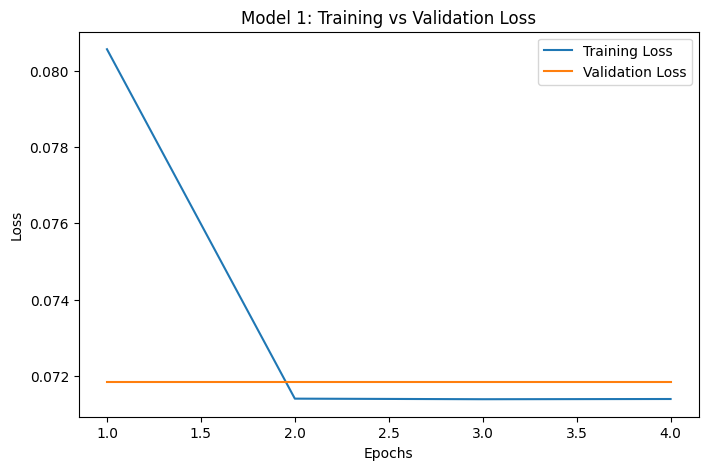

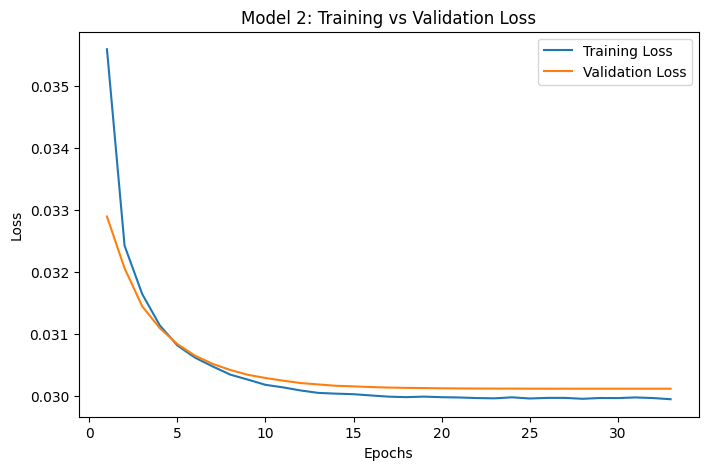

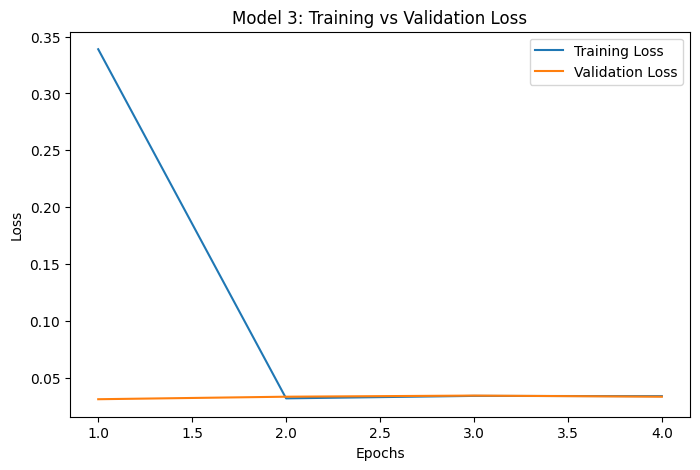

In [162]:
def plot_losses(train_losses, val_losses, title="Training vs Validation Loss"):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(train_loss_1, val_loss_1, title="Model 1: Training vs Validation Loss")
plot_losses(train_loss_2, val_loss_2, title="Model 2: Training vs Validation Loss")
plot_losses(train_loss_3, val_loss_3, title="Model 3: Training vs Validation Loss")

##Comparison with the Benchmark Model

Below is the benchmark model

**Benchmark model**

Neural network with 3 layers using ReLU activations. The model trained for 7 epochs until early stopping was triggered. The final score on the test set was 0.513 RMSLE.

**model 1**

my model 1 is with 3 ReLu activations. The model trained for 6 epochs until early stopping was triggered.The final score on the test set was 0.631

Compared to the benchmark, Model 1 has a higher RMSLE, indicating worse performance. The slightly shorter training period (6 vs. 7 epochs) might have contributed to the lower performance, or it might suggest that the model architecture and parameters are not as well-optimized for the problem at hand as those of the benchmark.

**model 2**

my model 2 is with 3 sigmoid activations. The model trained for 31 epochs until early stopping was triggered. The final score on the test set was 0.630

Model 2 also performs worse than the benchmark model, with a RMSLE similar to that of Model 1. The use of sigmoid activations and the significantly longer training time (31 epochs) did not result in better performance. This could be due to the characteristics of the sigmoid function, such as its tendency towards saturating gradients, which might not be as effective for this particular problem.

**model 3**

my model 3 is with 2 ReLU and 2 Sigmoid activations. The model is trained for 4 epochs until early stopping was triggered The final score on the test set was 0.580

Model 3 shows an improvement over Models 1 and 2, with a lower RMSLE compared to them but still higher than the benchmark. The mixed use of ReLU and sigmoid activations in a 4-layer architecture suggests a more complex model, which could potentially overfit if not carefully regularized or if trained for too many epochs. However, early stopping was triggered quite early (5 epochs), indicating either a fast convergence or a lack of significant improvement over iterations. Despite not reaching the benchmark's performance, Model 3 demonstrates the potential benefits of mixing activation functions and adjusting the network's depth.

##Conclusion
Model 1 and 2 underperform compared to the benchmark, while Model 3, with mixed activations and an extra layer, shows improvement but doesn't surpass it. Further optimization and regularization techniques may enhance performance.